# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.0: LB = 0.48866 CV = 0.463102
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML

## 1. Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier

# Importa pacotes do sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler


## 2. Carregando os dados de treino e teste

In [23]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino_modificado.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste_modificado.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [24]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 44 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 51 colunas


In [25]:
train.head()

,v31,v129,v50,v110,v66,v47,v38,v113,v56,v79,v24,v71,v74,v101,v3,v62,v30,v85,v72,v67,v100,v94,v84,v111,v95,v106,v108,v22,v125,v112,v52,v91,v107,v10_bin,v14_bin,v26_bin,v28_bin,v34_bin,v46_bin,v55_bin,v57_bin,v58_bin,v65_bin,target
0,0,0,0.111270,0,0,0,0,0,0,0,0,0,0,0.386152,0,1,0,0.269716,1,0.598997,0.141689,0.281723,0.139374,0.338176,0.212921,0.495177,0.131094,0,0,0,0,0,0,49,45,122,175,141,251,138,9,106,128,0
1,0,0,0.163392,0,1,1,0,1,1,1,1,1,0,0.000000,0,1,1,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,1,0,0,61,35,0,0,175,0,0,0,0,0,1
2,0,0,0.146414,0,0,2,0,0,2,2,2,1,0,0.233377,0,1,-1,0.328590,1,0.441279,0.764561,0.239724,0.172676,0.340090,0.163506,0.407940,0.135128,2,2,1,0,0,0,61,58,30,175,62,124,138,21,54,37,1
3,0,0,0.053418,0,2,1,0,0,-1,3,1,1,0,0.000000,0,2,-1,0.000000,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,3,2,2,1,1,38,43,0,0,62,0,0,0,0,0,0
4,1,0,0.171427,1,1,3,6,-1,3,4,0,1,1,0.398321,0,0,-1,0.114583,6,0.506923,0.973248,0.197568,0.128673,0.236744,0.170047,0.612259,0.132526,4,4,3,3,0,0,55,137,54,69,120,15,32,61,22,151,1


In [26]:
test.head()

,v31,v129,v50,v110,v66,v47,v38,v113,v56,v79,v24,v71,v74,v101,v3,v62,v30,v85,v72,v67,v100,v94,v84,v111,v95,v106,v108,v22,v125,v112,v52,v91,v107,v10_bin,v14_bin,v26_bin,v28_bin,v34_bin,v46_bin,v55_bin,v57_bin,v58_bin,v65_bin,target_Logistic Regression_predictions,target_Linear Discriminant_predictions,target_Naive Bayes_predictions,target_Bagging_predictions,target_CatBoost_predictions,Class_proba_0,Class_proba_1,target_Ensembled_predictions
0,0,0,0.053278,0,2,2,0,-1,2,2,1,1,0,0.246990,0,1,-1,0.136213,1,0.429988,0.986097,0.199456,0.090104,0.217561,0.174763,0.604196,0.119166,10794,19,7,7,3,3,49,100,30,43,62,16,52,9,10,129,1,1,0,0,0,0.707753,0.292247,0
1,0,0,0.096527,1,1,3,4,-1,4,6,3,1,0,0.000000,0,1,4,0.000000,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113,53,14,10,2,2,48,44,0,0,212,0,0,0,0,0,1,1,1,1,1,0.119297,0.880703,1
2,0,0,0.087654,0,1,1,0,1,28,3,0,1,0,0.358836,0,1,1,0.136213,1,0.480519,0.990476,0.208014,0.084725,0.196042,0.159372,0.607002,0.104227,18210,66,17,10,2,2,55,158,163,16,158,2,21,141,0,129,1,1,1,1,1,0.293546,0.706454,1
3,0,0,0.092684,0,0,1,0,0,0,3,1,1,0,0.220365,0,1,5,0.333333,1,0.447680,0.053150,0.303320,0.248601,0.234898,0.200637,0.331290,0.175756,2444,65,5,10,3,3,55,38,49,175,114,207,182,95,131,21,1,1,1,1,1,0.357478,0.642522,1
4,0,0,0.118745,0,0,1,0,13,-1,3,1,1,0,0.362228,0,2,1,0.092971,2,0.498549,0.963224,0.244056,0.073417,0.134688,0.140762,0.746046,0.165096,7527,36,16,8,3,3,38,45,153,152,69,27,21,141,36,170,1,1,1,1,1,0.267498,0.732502,1


## 3. Feature Engineering

In [27]:
test = test[test.columns[:-8]]

In [28]:
df = train.append(test)

In [29]:
df.head()

,target,v100,v101,v106,v107,v108,v10_bin,v110,v111,v112,v113,v125,v129,v14_bin,v22,v24,v26_bin,v28_bin,v3,v30,v31,v34_bin,v38,v46_bin,v47,v50,v52,v55_bin,v56,v57_bin,v58_bin,v62,v65_bin,v66,v67,v71,v72,v74,v79,v84,v85,v91,v94,v95
0,0.0,0.141689,0.386152,0.495177,0,0.131094,49,0,0.338176,0,0,0,0,45,0,0,122,175,0,0,0,141,0,251,0,0.111270,0,138,0,9,106,1,128,0,0.598997,0,1,0,0,0.139374,0.269716,0,0.281723,0.212921
1,1.0,0.000000,0.000000,0.000000,0,0.000000,61,0,0.000000,0,1,1,0,35,1,1,0,0,0,1,0,175,0,0,1,0.163392,1,0,1,0,0,1,0,1,0.000000,1,1,0,1,0.000000,0.000000,0,0.000000,0.000000
2,1.0,0.764561,0.233377,0.407940,0,0.135128,61,0,0.340090,1,0,2,0,58,2,2,30,175,0,-1,0,62,0,124,2,0.146414,0,138,2,21,54,1,37,0,0.441279,1,1,0,2,0.172676,0.328590,0,0.239724,0.163506
3,0.0,0.000000,0.000000,0.000000,1,0.000000,38,0,0.000000,2,0,3,0,43,3,1,0,0,0,-1,0,62,0,0,1,0.053418,2,0,-1,0,0,2,0,2,0.000000,1,2,0,3,0.000000,0.000000,1,0.000000,0.000000
4,1.0,0.973248,0.398321,0.612259,0,0.132526,55,1,0.236744,3,-1,4,0,137,4,0,54,69,0,-1,1,120,6,15,3,0.171427,3,32,3,61,22,0,151,1,0.506923,1,6,1,4,0.128673,0.114583,0,0.197568,0.170047


## 4. Criar e avaliar alguns algoritmos de Machine Learning

## 4.1. Algoritmo LigthGBM


In [59]:
# Configurações Gerais

GENERATE_SUBMISSION_FILES = True
SUBMISSION_SUFIX = "_lgbm_v.1.0.0"
STRATIFIED_KFOLD = False
RANDOM_SEED = 737851
NUM_THREADS = 4
NUM_FOLDS = 10
EARLY_STOPPING = 100

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

In [60]:
# ------------------------- LIGHTGBM MODEL -------------------------

def run_model(data, categorical_feature = None):
    df = data[data['target'].notnull()]
    test = data[data['target'].isnull()]
    del_features = ['target']
    predictors = list(filter(lambda v: v not in del_features, df.columns))
    
    print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    sub_preds = np.zeros(test.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['target'])):
        train_x, train_y = df[predictors].iloc[train_idx], df['target'].iloc[train_idx]
        valid_x, valid_y = df[predictors].iloc[valid_idx], df['target'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        if not categorical_feature:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', verbose=400, early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', verbose=400, early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(df[predictors].columns), categorical_feature= categorical_feature)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[predictors], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['binary_logloss']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['binary_logloss']

        print('Fold %2d Log Loss : %.6f' % (n_fold + 1, log_loss(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full Log Loss score %.6f' % log_loss(df['target'], oof_preds))
    test['target'] = sub_preds.copy()

    # Get the average feature importance between folds
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    # Save feature importance, test predictions and oof predictions as csv
    if GENERATE_SUBMISSION_FILES:

        # Save submission (test data) and feature importance
        submission = pd.read_csv('../dataset/sample_submission.csv')
        submission['PredictedProb'] = sub_preds.copy()
        submission.to_csv('../submission/submission{}.csv'.format(SUBMISSION_SUFIX), index=False)
        
        mean_importance.to_csv('feature_importance{}.csv'.format(SUBMISSION_SUFIX), index=False)
        plt.hist(submission.PredictedProb)
        plt.show()
    return mean_importance

Train/valid shape: (114321, 44), test shape: (114393, 44)
Training until validation scores don't improve for 100 rounds
[400]	training's binary_logloss: 0.472541	valid_1's binary_logloss: 0.483575
[800]	training's binary_logloss: 0.456789	valid_1's binary_logloss: 0.474793
[1200]	training's binary_logloss: 0.447137	valid_1's binary_logloss: 0.472385
[1600]	training's binary_logloss: 0.439081	valid_1's binary_logloss: 0.470907
[2000]	training's binary_logloss: 0.431718	valid_1's binary_logloss: 0.470128
[2400]	training's binary_logloss: 0.424954	valid_1's binary_logloss: 0.469402
[2800]	training's binary_logloss: 0.418593	valid_1's binary_logloss: 0.468991
Early stopping, best iteration is:
[2717]	training's binary_logloss: 0.419845	valid_1's binary_logloss: 0.468917
Fold  1 Log Loss : 0.468917
Training until validation scores don't improve for 100 rounds
[400]	training's binary_logloss: 0.472502	valid_1's binary_logloss: 0.481706
[800]	training's binary_logloss: 0.456544	valid_1's bina

[2800]	training's binary_logloss: 0.419584	valid_1's binary_logloss: 0.458665
[3200]	training's binary_logloss: 0.413472	valid_1's binary_logloss: 0.458277
[3600]	training's binary_logloss: 0.407714	valid_1's binary_logloss: 0.457647
[4000]	training's binary_logloss: 0.402174	valid_1's binary_logloss: 0.457237
Early stopping, best iteration is:
[4115]	training's binary_logloss: 0.400611	valid_1's binary_logloss: 0.457072
Fold 10 Log Loss : 0.457072
Full Log Loss score 0.463102


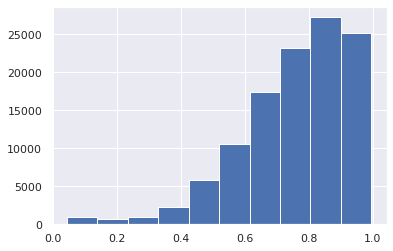

,feature,gain,split
24,v50,1.069258e+06,14800.2
13,v22,2.967359e+05,10396.1
27,v56,2.897258e+05,8728.0
32,v66,2.767922e+05,3622.4
5,v10_bin,2.592728e+05,8304.6
20,v34_bin,2.313032e+05,6983.0
10,v125,2.195386e+05,7770.6
12,v14_bin,2.111776e+05,7327.7
0,v100,1.707931e+05,6172.1
4,v108,1.674346e+05,6124.2


In [61]:
run_model(df)